<a href="https://colab.research.google.com/github/NickygenN1/DeepImage/blob/main/predict_custom_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation

In [3]:
!git clone https://github.com/NickygenN1/DeepImage.git
!pip install torch torchvision matplotlib
%cd DeepImage

fatal: destination path 'DeepImage' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import os 
import torch 
import torchvision
from torch import nn
from PIL import Image 
from torchvision import transforms
import matplotlib.pyplot as plt

class DeepImage(nn.Module) :
    def __init__(self, n_classes=3) :
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3,3))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.3)
        self.output = nn.Linear(in_features=34992, out_features=n_classes)

    def forward(self, x) :
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.output(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_names = ['husky', 'mumbai cat', 'shiba inu']
trained_model = DeepImage(n_classes = 3).to(device)
trained_model.load_state_dict(torch.load(f='./best_ImageClassifierV1_.pt', map_location=device))


custom_images_dir = './custom_images'
if not os.path.isdir(custom_images_dir) :
    os.mkdir(custom_images_dir)


def ToJPG(image_path:str) :
    if not image_path.endswith('jpg') :
        image = Image.open(image_path).convert('RGB')
        image_name = image_path.split('.')[:-1]
        image_name = ''.join(image_name)
        image.save(f'.{image_name}.jpg')
        os.remove(image_path)

def ToTensor(image_path:str) :
    transformer = transforms.Resize((224, 224))
    image = torchvision.io.read_image(image_path).type(torch.float32) / 255.
    image_transform = transformer(image)
    return image_transform

def predict(image_tensor:torch.tensor) :
    trained_model.eval()
    with torch.inference_mode() :
        predict = trained_model(image_tensor.unsqueeze(dim=0))
        probas = torch.softmax(predict, dim=1)
        predict_idx  = torch.argmax(probas, dim=1)
        predict_class = class_names[predict_idx]
    
    return predict_class, probas

def plot_predict(image_tensor:torch.tensor) :
    class_, probas = predict(image_tensor)
    confident = torch.max(probas[0])*100
    plt.imshow(image_tensor.permute(1,2,0))
    plt.title(f'{class_} {confident:.2f}%')
    plt.axis('off')

## Uploade images

In [19]:
print(f'upload images to "{custom_images_dir}" for prediction')
uploaded = input('already uploaded ? (y/n) : ')
if uploaded.lower() == 'n' :
    print('have to upload before run the next cell')

upload images to "./custom_images" for prediction
already uploaded ? (y/n) : y


## Prediction

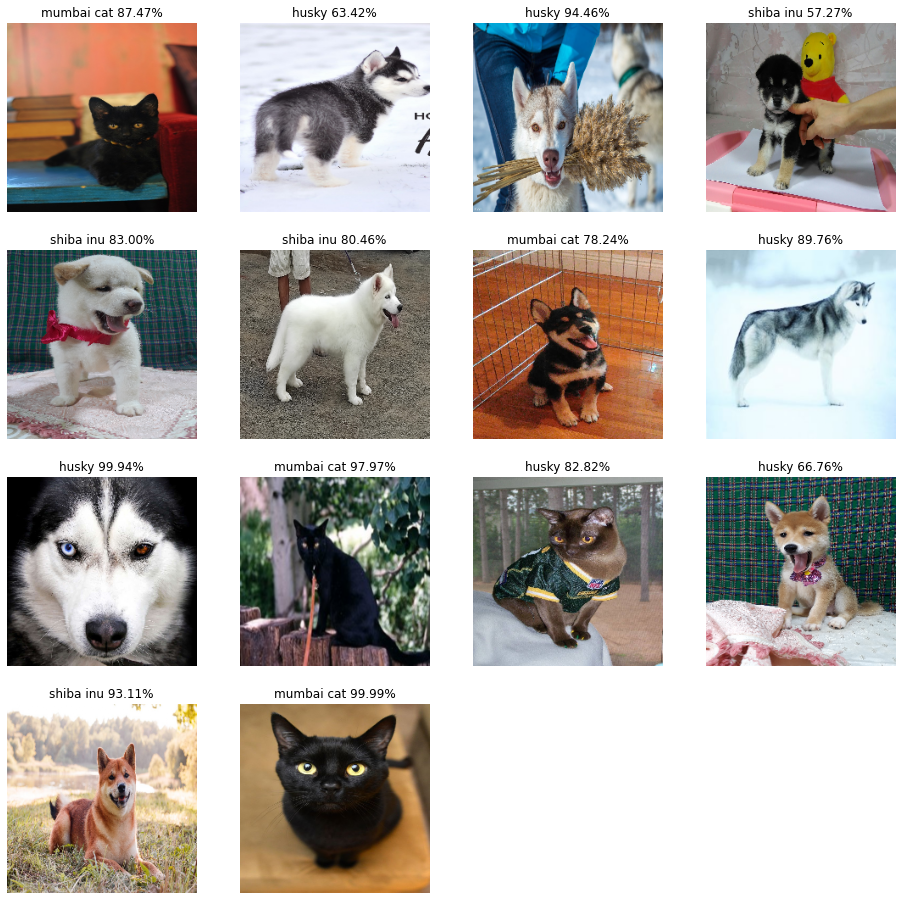

In [22]:
import random

# to jpg format
images_path = [os.path.join(custom_images_dir, image_name) for image_name in os.listdir(custom_images_dir)]
for image in images_path :
    ToJPG(image)
images_path = [os.path.join(custom_images_dir, image_name) for image_name in os.listdir(custom_images_dir)]

plt.figure(figsize=(16, 16))
sample_predict = random.sample(images_path, 16 if len(images_path) >= 16 else len(images_path))
for i, image in enumerate(sample_predict, start=1) :
    imageTensor = ToTensor(image)
    plt.subplot(4, 4, i)
    plot_predict(imageTensor)